In [1]:
import os
import torch
import matplotlib.pyplot as plt
import torchvision
from torch import nn
from torchvision import transforms

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
train_dir = 'D:/Refined 7 Dataset/Plant Village dataset/PlantVillage/train'
test_dir = 'D:/Refined 7 Dataset/Plant Village dataset/PlantVillage/test'

In [4]:
IMG_SIZE = 224
IN_CHANNELS = 3
NUM_CLASSES = 38
BATCH_SIZE = 32
PATCH_SIZE = 16
NUM_WORKERS = os.cpu_count()
NUM_TRANSFORMER_LAYERS = 4
NUM_HEADS = 12
ATTN_DROPOUT = 0
MLP_DROPOUT = 0.1
EMBD_DROPOUT = 0.1
NUM_EPOCHS = 100
LRN_RATE = 1e-4
WEIGHT_DECAY = 0.001

In [5]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int):

    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)

    class_names = train_data.classes

    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    return train_dataloader, test_dataloader, class_names

In [6]:
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms, 
    batch_size = BATCH_SIZE,
    num_workers = NUM_WORKERS
)

(<torch.utils.data.dataloader.DataLoader at 0x194c48a2360>,
 ['Apple___Apple_scab',
  'Apple___Black_rot',
  'Apple___Cedar_apple_rust',
  'Apple___healthy',
  'Blueberry___healthy',
  'Cherry_(including_sour)___Powdery_mildew',
  'Cherry_(including_sour)___healthy',
  'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
  'Corn_(maize)___Common_rust_',
  'Corn_(maize)___Northern_Leaf_Blight',
  'Corn_(maize)___healthy',
  'Grape___Black_rot',
  'Grape___Esca_(Black_Measles)',
  'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
  'Grape___healthy',
  'Orange___Haunglongbing_(Citrus_greening)',
  'Peach___Bacterial_spot',
  'Peach___healthy',
  'Pepper,_bell___Bacterial_spot',
  'Pepper,_bell___healthy',
  'Potato___Early_blight',
  'Potato___Late_blight',
  'Potato___healthy',
  'Raspberry___healthy',
  'Soybean___healthy',
  'Squash___Powdery_mildew',
  'Strawberry___Leaf_scorch',
  'Strawberry___healthy',
  'Tomato___Bacterial_spot',
  'Tomato___Early_blight',
  'Tomato___Late_blight',


In [8]:
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """ 
    def __init__(self, 
                 in_channels:int,
                 patch_size:int,
                 embedding_dim:int):
        super().__init__()
        
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        self.flatten = nn.Flatten(start_dim=2, end_dim=3)

    def forward(self, x):
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        return x_flattened.permute(0, 2, 1)

In [9]:
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [10]:
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    def __init__(self,
                 embedding_dim:int,
                 num_heads:int,
                 attn_dropout:float):
        super().__init__()
        
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)
        
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x,
                                             key=x,
                                             value=x,
                                             need_weights=False)
        return attn_output

In [11]:
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    def __init__(self,
                 embedding_dim:int,
                 mlp_size:int,
                 dropout:float):
        super().__init__()
        
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )
    
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [12]:
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    def __init__(self,
                 embedding_dim:int,
                 num_heads:int,
                 mlp_size:int,
                 mlp_dropout:float,
                 attn_dropout:float):
        super().__init__()

        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim, num_heads=num_heads, attn_dropout=attn_dropout)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim, mlp_size=mlp_size, dropout=mlp_dropout)
        
    def forward(self, x):
        x = self.msa_block(x) + x
        x = self.mlp_block(x) + x
        return x

In [13]:
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    def __init__(self,
                 img_size:int=IMG_SIZE,
                 in_channels:int=IN_CHANNELS,
                 patch_size:int=PATCH_SIZE,
                 num_transformer_layers:int=NUM_TRANSFORMER_LAYERS,
                 embedding_dim:int=(PATCH_SIZE**2)*3,
                 mlp_size:int=(PATCH_SIZE**2)*3*4,
                 num_heads:int=NUM_HEADS,
                 attn_dropout:float=ATTN_DROPOUT,
                 mlp_dropout:float=MLP_DROPOUT,
                 embedding_dropout:float=EMBD_DROPOUT,
                 num_classes:int=NUM_CLASSES):
        super().__init__()
        
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
        
        self.num_patches = (img_size * img_size) // patch_size**2
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim), requires_grad=True)
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim), requires_grad=True)
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)        
        self.patch_embedding = PatchEmbedding(in_channels=in_channels, patch_size=patch_size, embedding_dim=embedding_dim)
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout,
                                                                            attn_dropout=attn_dropout) for _ in range(num_transformer_layers)])
       
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, out_features=num_classes)
        )
    
    def forward(self, x):
        batch_size = x.shape[0]
        class_token = self.class_embedding.expand(batch_size, -1, -1)
        x = self.patch_embedding(x)
        x = torch.cat((class_token, x), dim=1)
        x = self.position_embedding + x
        x = self.embedding_dropout(x)
        x = self.transformer_encoder(x)
        x = self.classifier(x[:, 0])
        return x       

In [14]:
vit = ViT(img_size=IMG_SIZE,
          in_channels=IN_CHANNELS,
          patch_size=PATCH_SIZE,
          num_transformer_layers=NUM_TRANSFORMER_LAYERS,
          embedding_dim=(PATCH_SIZE**2)*3,
          mlp_size=(PATCH_SIZE**2)*3*4,
          num_heads=NUM_HEADS,
          attn_dropout=ATTN_DROPOUT,
          mlp_dropout=MLP_DROPOUT,
          embedding_dropout=EMBD_DROPOUT,
          num_classes=NUM_CLASSES
        )

In [15]:
from torchinfo import summary
summary(model=vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

C:\Users\cnky2\anaconda3\envs\manu\Lib\site-packages\torch\nn\modules\activation.py:1230: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  return torch._native_multi_head_attention(


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 38]              152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

In [16]:
from going_modular.going_modular import engine
optimizer = torch.optim.Adam(params=vit.parameters(), 
                             lr=LRN_RATE,
                             betas=(0.9, 0.999),
                             weight_decay=WEIGHT_DECAY)

loss_fn = torch.nn.CrossEntropyLoss()
set_seeds()

In [17]:
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=NUM_EPOCHS,
                       device=device)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5838 | train_acc: 0.5499 | test_loss: 0.8487 | test_acc: 0.7362
Epoch: 2 | train_loss: 0.6150 | train_acc: 0.8077 | test_loss: 0.6041 | test_acc: 0.8108
Epoch: 3 | train_loss: 0.4140 | train_acc: 0.8696 | test_loss: 0.3593 | test_acc: 0.8843
Epoch: 4 | train_loss: 0.3287 | train_acc: 0.8969 | test_loss: 0.3165 | test_acc: 0.8947
Epoch: 5 | train_loss: 0.2744 | train_acc: 0.9132 | test_loss: 0.2387 | test_acc: 0.9222
Epoch: 6 | train_loss: 0.2432 | train_acc: 0.9242 | test_loss: 0.2457 | test_acc: 0.9196
Epoch: 7 | train_loss: 0.2237 | train_acc: 0.9311 | test_loss: 0.2862 | test_acc: 0.9106
Epoch: 8 | train_loss: 0.2118 | train_acc: 0.9330 | test_loss: 0.2339 | test_acc: 0.9232
Epoch: 9 | train_loss: 0.1949 | train_acc: 0.9398 | test_loss: 0.2042 | test_acc: 0.9353
Epoch: 10 | train_loss: 0.1851 | train_acc: 0.9448 | test_loss: 0.2125 | test_acc: 0.9312
Epoch: 11 | train_loss: 0.1774 | train_acc: 0.9459 | test_loss: 0.1832 | test_acc: 0.9396
Epoch: 12 | train_l

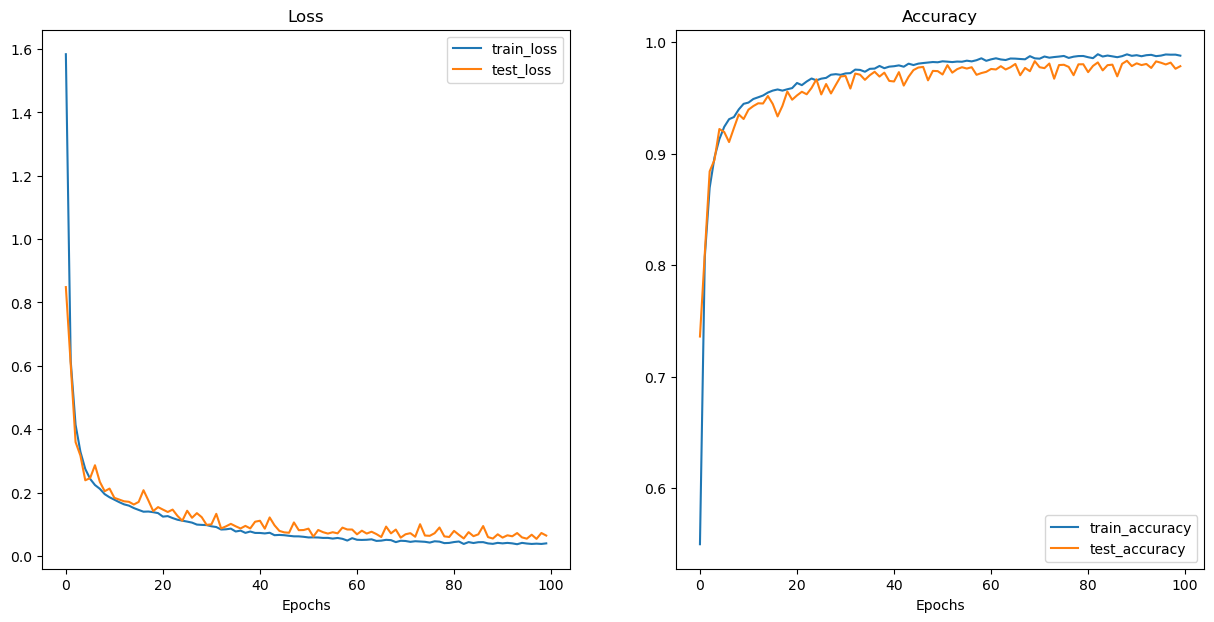

In [18]:
from helper_functions import plot_loss_curves
plot_loss_curves(results)

In [19]:
import pandas as pd
results_df = pd.DataFrame(results)
results_df.to_csv('training_results.csv', index=False)

In [20]:
torch.save(vit.state_dict(), 'vit_16x16_PlantVillage.pth')